* 全データで隠れ状態をイニング、右左、序盤か終盤かでHMMを学習

In [1]:
import pandas as pd
df=pd.read_csv("statcast_data_pitch_categori.csv")
pd.set_option('display.max_columns', None)  # カラムの表示制限を解除
pd.set_option('display.width', 1000)        # 横幅も広げる（必要なら）
print(df.head(200))

     Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  release_pos_z    player_name  batter  pitcher     events    description  zone                                                des game_type stand p_throws home_team away_team type  hit_location      bb_type  balls  strikes  game_year  pfx_x  pfx_z  plate_x  plate_z  on_3b  on_2b  on_1b  outs_when_up  inning inning_topbot    hc_x    hc_y        vx0         vy0       vz0         ax         ay         az  sz_top  sz_bot  hit_distance_sc  launch_speed  launch_angle  effective_speed  release_spin_rate  release_extension  game_pk  fielder_2  fielder_3  fielder_4  fielder_5  fielder_6  fielder_7  fielder_8  fielder_9  release_pos_y  estimated_ba_using_speedangle  estimated_woba_using_speedangle  woba_value  woba_denom  babip_value  iso_value  launch_speed_angle  at_bat_number  pitch_number       pitch_name  home_score  away_score  bat_score  fld_score  post_away_score  post_home_score  post_bat_score  post_fld_score  \
0    

In [2]:
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# 日本語対応フォント候補を抽出して表示
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if any(x in font.lower() for x in ['gothic', 'meiryo', 'noto', 'ipa', 'takao']):
        print(font)
# 日本語フォント設定
jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')
rcParams['font.family'] = jp_font.get_name()
rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策

/usr/share/fonts/truetype/takao-mincho/TakaoPMincho.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc
/usr/share/fonts/truetype/takao-mincho/TakaoMincho.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Black.ttc
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf
/usr/share/fonts/truetype/noto/NotoColorEmoji.ttf
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-ExtraLight.ttc
/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf
/usr/share/fonts/meiryo/meiryo.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Thin.ttc
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf
/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf
/usr/share/fonts/opentype/ipafont-

In [3]:
!pip install hmmlearn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# カテゴリを整数に変換
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import CategoricalHMM
from hmmlearn.hmm import GaussianHMM
import numpy as np
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import CategoricalHMM

In [5]:
df['runner_str'] = (
        df['on_1b'].notnull().astype(int).astype(str) +
        df['on_2b'].notnull().astype(int).astype(str) +
        df['on_3b'].notnull().astype(int).astype(str)
    )

In [6]:
df = df[(df["balls"] <= 3) & (df["strikes"] <= 2)]
import numpy as np
from sklearn.model_selection import train_test_split
#import ace_tools as tools

# ピッチャー単位で train/test に分割し、split カラムを追加
df["split"] = "none"
for pid, pitcher_df in df.groupby("pitcher"):
    games = pitcher_df["game_pk"].unique()
    if pitcher_df.shape[0] < 10 or len(games) < 2:
        continue

    train_games, test_games = train_test_split(games, test_size=0.3, shuffle=False, random_state=42)

    df.loc[(df["pitcher"] == pid) & (df["game_pk"].isin(train_games)), "split"] = "train"
    df.loc[(df["pitcher"] == pid) & (df["game_pk"].isin(test_games)), "split"] = "test"

In [7]:
# 観測値をエンコード（球種 × コース）
df = df[df["zone"].notnull() & df["pitch_cluster_label"].notnull()]
df["pitch_obs"] = df["pitch_cluster_label"] + "_" + df["zone"].astype(str)
obs_encoder = LabelEncoder()
df["obs_encoded"] = obs_encoder.fit_transform(df["pitch_obs"])

# 状態（隠れ変数）の構築
def calc_score_class(diff):
    if diff > 0:
        return "win"
    elif diff == 0:
        return "tie"
    else:
        return "lose"

df["score_diff"] = df["home_score"] - df["away_score"]
df["score_class"] = df["score_diff"].apply(calc_score_class)

df["hand_match"] = (df["stand"] == df["p_throws"]).map({True: "same", False: "diff"})
df["inning_class"] = df["inning"].apply(lambda x: "early" if x <= 6 else "late")

df["state_str"] = df["score_class"] + "_" + df["hand_match"] + "_" + df["inning_class"]
state_encoder = LabelEncoder()
df["situation_encoded"] = state_encoder.fit_transform(df["state_str"])

n_states = df["situation_encoded"].nunique()
n_obs = df["obs_encoded"].nunique()


In [8]:
# trainデータだけ抽出
train_df = df[df["split"] == "train"]

X_train = train_df["obs_encoded"].astype(int).values.reshape(-1, 1)
lengths_train = train_df.groupby(["pitcher", "game_pk"]).size().values.astype(int)

from hmmlearn.hmm import CategoricalHMM
model = CategoricalHMM(n_components=n_states, n_iter=100, n_features=n_obs, verbose=True)
model.fit(X_train, lengths=lengths_train)

B_pred = model.emissionprob_


         1 -9531933.16241831             +nan
         2 -8796893.68291020 +735039.47950811
         3 -8659913.20575972 +136980.47715048
         4 -8503483.68739417 +156429.51836554
         5 -8441949.65942765  +61534.02796652
         6 -8417924.02400515  +24025.63542250
         7 -8405993.21071478  +11930.81329037
         8 -8398124.81745450   +7868.39326028
         9 -8391880.88384108   +6243.93361342
        10 -8386728.45817236   +5152.42566872
        11 -8382550.77087425   +4177.68729811
        12 -8379234.65335485   +3316.11751941
        13 -8376622.57981628   +2612.07353857
        14 -8374548.79869129   +2073.78112499
        15 -8372870.31630856   +1678.48238273
        16 -8371477.59907402   +1392.71723454
        17 -8370292.07961569   +1185.51945833
        18 -8369258.98865244   +1033.09096325
        19 -8368340.26930083    +918.71935161
        20 -8367509.16528388    +831.10401694
        21 -8366746.51970260    +762.64558129
        22 -8366038.34698520    +7

In [21]:
import pickle

# 保存
with open('trained_hmm_ininng.pkl', 'wb') as f:
    pickle.dump(model, f)


In [22]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

test_df = df[df["split"] == "test"]

X_test = test_df[df["split"] == "test"]["obs_encoded"].astype(int).values.reshape(-1, 1)
lengths_test = test_df.groupby(["pitcher", "game_pk"]).size().values.astype(int)

true_states = test_df["situation_encoded"].values
_, pred_states = model.decode(X_test)

cm = confusion_matrix(true_states, pred_states)
row_ind, col_ind = linear_sum_assignment(-cm)

mapping = {pred: true for pred, true in zip(col_ind, row_ind)}


/tmp/ipykernel_3610862/533064057.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = test_df[df["split"] == "test"]["obs_encoded"].astype(int).values.reshape(-1, 1)


In [23]:
B_pred_mapped = B_pred[list(mapping.keys()), :]
B_pred_mapped = B_pred_mapped[[mapping[i] for i in range(len(mapping))]]


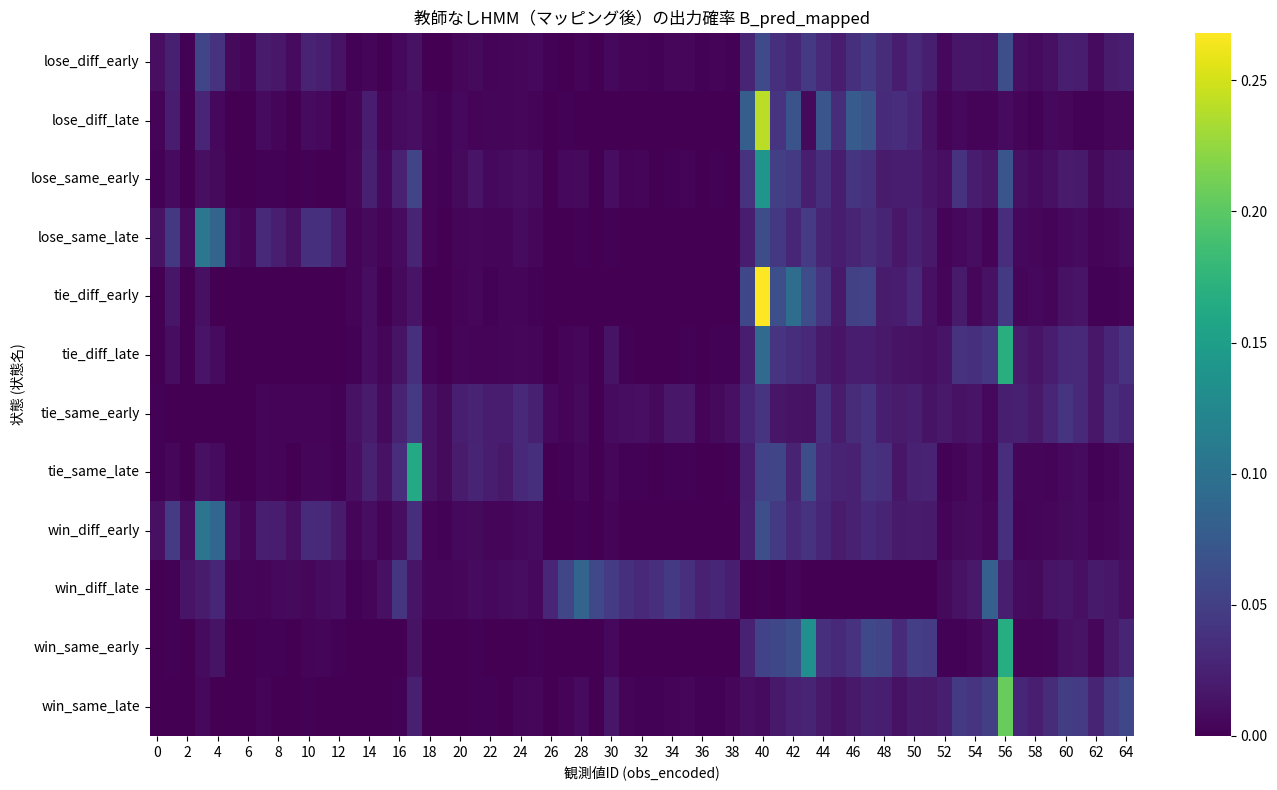

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 逆変換で状態名を復元（例: "win_same_early"）
state_labels = state_encoder.inverse_transform(range(B_pred_mapped.shape[0]))

# DataFrame にしてラベルつける
df_b_pred = pd.DataFrame(B_pred_mapped, index=state_labels)

# ヒートマップ描画
plt.figure(figsize=(14, 8))
sns.heatmap(df_b_pred, cmap="viridis", annot=False, cbar=True)
plt.title("教師なしHMM（マッピング後）の出力確率 B_pred_mapped")
plt.xlabel("観測値ID (obs_encoded)")
plt.ylabel("状態 (状態名)")
plt.tight_layout()
plt.show()


In [25]:
# 数え上げ
import numpy as np

n_states = df["situation_encoded"].nunique()
n_obs = df["obs_encoded"].nunique()

pi = np.zeros(n_states)
A = np.zeros((n_states, n_states))
B = np.zeros((n_states, n_obs))

train_df = df[df["split"] == "train"]

for (pid, game), group in train_df.groupby(["pitcher", "game_pk"]):
    states = group["situation_encoded"].values
    obs = group["obs_encoded"].values

    if len(states) < 2:
        continue

    pi[states[0]] += 1  # 初期状態

    for i in range(1, len(states)):
        A[states[i - 1], states[i]] += 1  # 状態遷移

    for s, o in zip(states, obs):
        B[s, o] += 1  # 出力

# 正規化
pi /= pi.sum()

A_row_sums = A.sum(axis=1, keepdims=True)
A = np.divide(A, A_row_sums, where=A_row_sums != 0)

B_row_sums = B.sum(axis=1, keepdims=True)
B = np.divide(B, B_row_sums, where=B_row_sums != 0)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# pi の可視化（棒グラフ）
def plot_initial_probabilities(pi, state_labels=None):
    plt.figure(figsize=(16, 5))

    x = range(len(pi))
    labels = state_labels if state_labels is not None else x

    plt.bar(x, pi, color="steelblue")
    plt.xticks(ticks=x, labels=labels, rotation=90, fontsize=10)
    plt.xlabel("State")
    plt.ylabel("初期状態 (π)")
    plt.title("初期状態確率(π)")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# A の可視化（ヒートマップ）
def plot_transition_matrix(A_df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(A_df,xticklabels=state_encoder.classes_,yticklabels=state_encoder.classes_ ,cmap="YlGnBu", cbar=True)
    plt.title("遷移確立 (A)")
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.tight_layout()
    plt.show()

# B の可視化（ヒートマップ）
#short_obs_labels = [label.replace("_", "") for label in obs_encoder.classes_]
#short_state_labels = [label.replace("-", "") for label in situation_encoder.classes_]

short_obs_labels = [
    str(label).replace("_", "") if isinstance(label, str) else str(label)
    for label in obs_encoder.classes_
]

short_state_labels = [
    str(label).replace("-", "") if isinstance(label, str) else str(label)
    for label in state_encoder.classes_
]
def plot_emission_matrix(B_df):
    plt.figure(figsize=(18, 10))
    ax = sns.heatmap(B_df, xticklabels=short_obs_labels, yticklabels=short_state_labels, cmap="YlGnBu", cbar=True)
    plt.title("出力確率(B)")
    plt.xlabel("Observation")
    plt.ylabel("State")

    # ラベル間引きと回転
    #ax.set_xticks(np.arange(0, len(short_obs_labels), 10))
    #ax.set_xticklabels(short_obs_labels[::10], rotation=90)

    plt.tight_layout()
    plt.show()


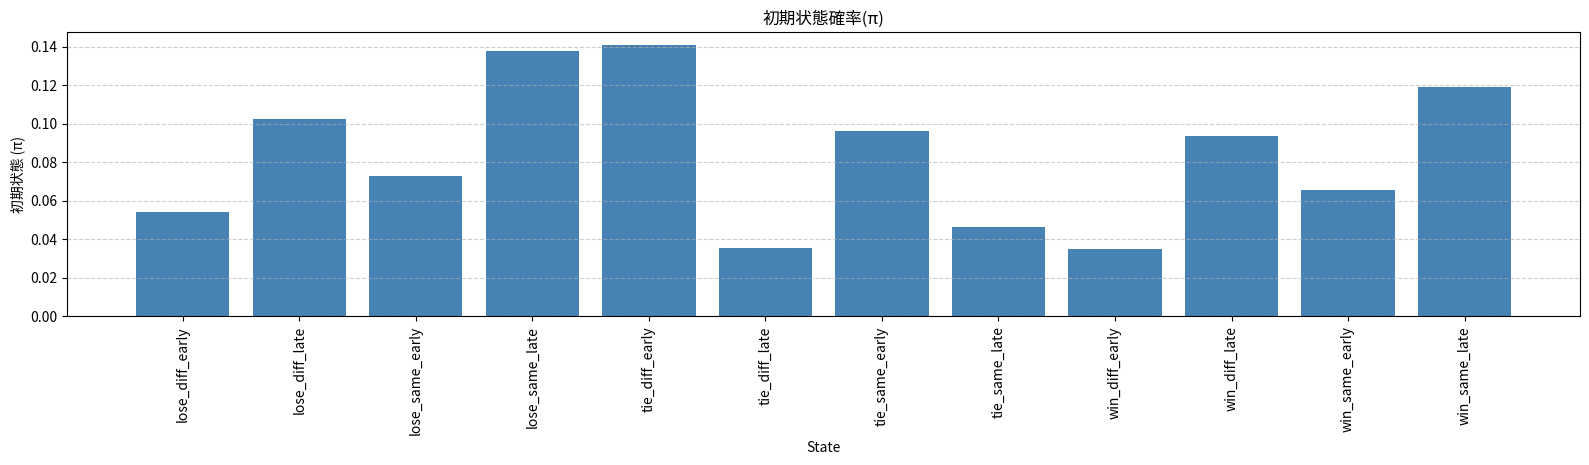

In [27]:
plot_initial_probabilities(pi,state_labels=short_state_labels)


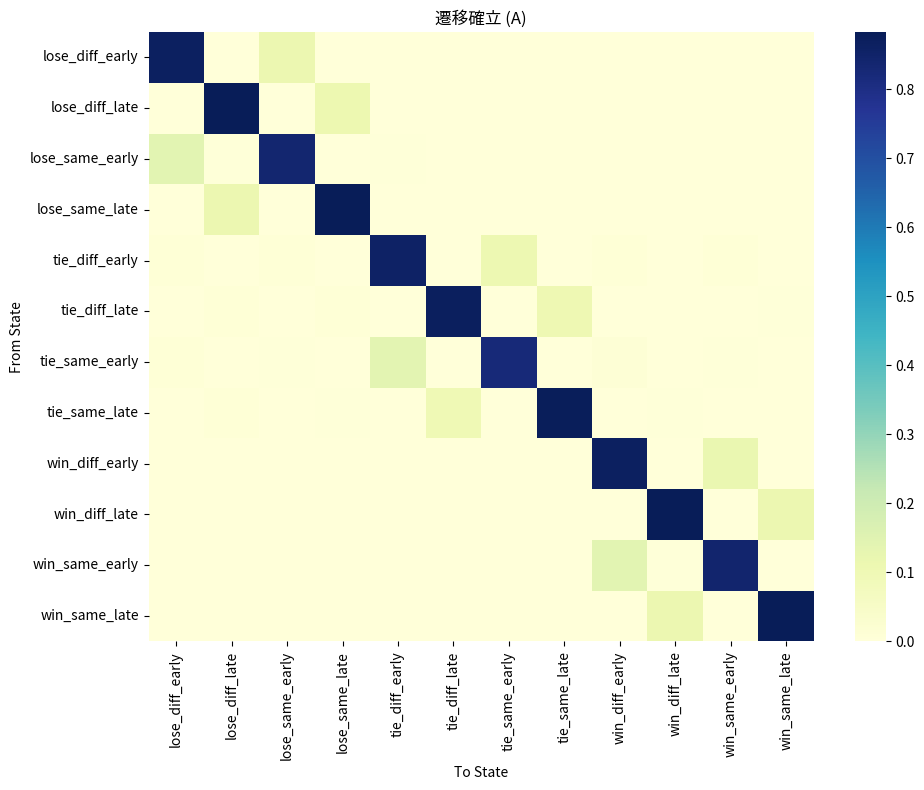

In [28]:
plot_transition_matrix(A)

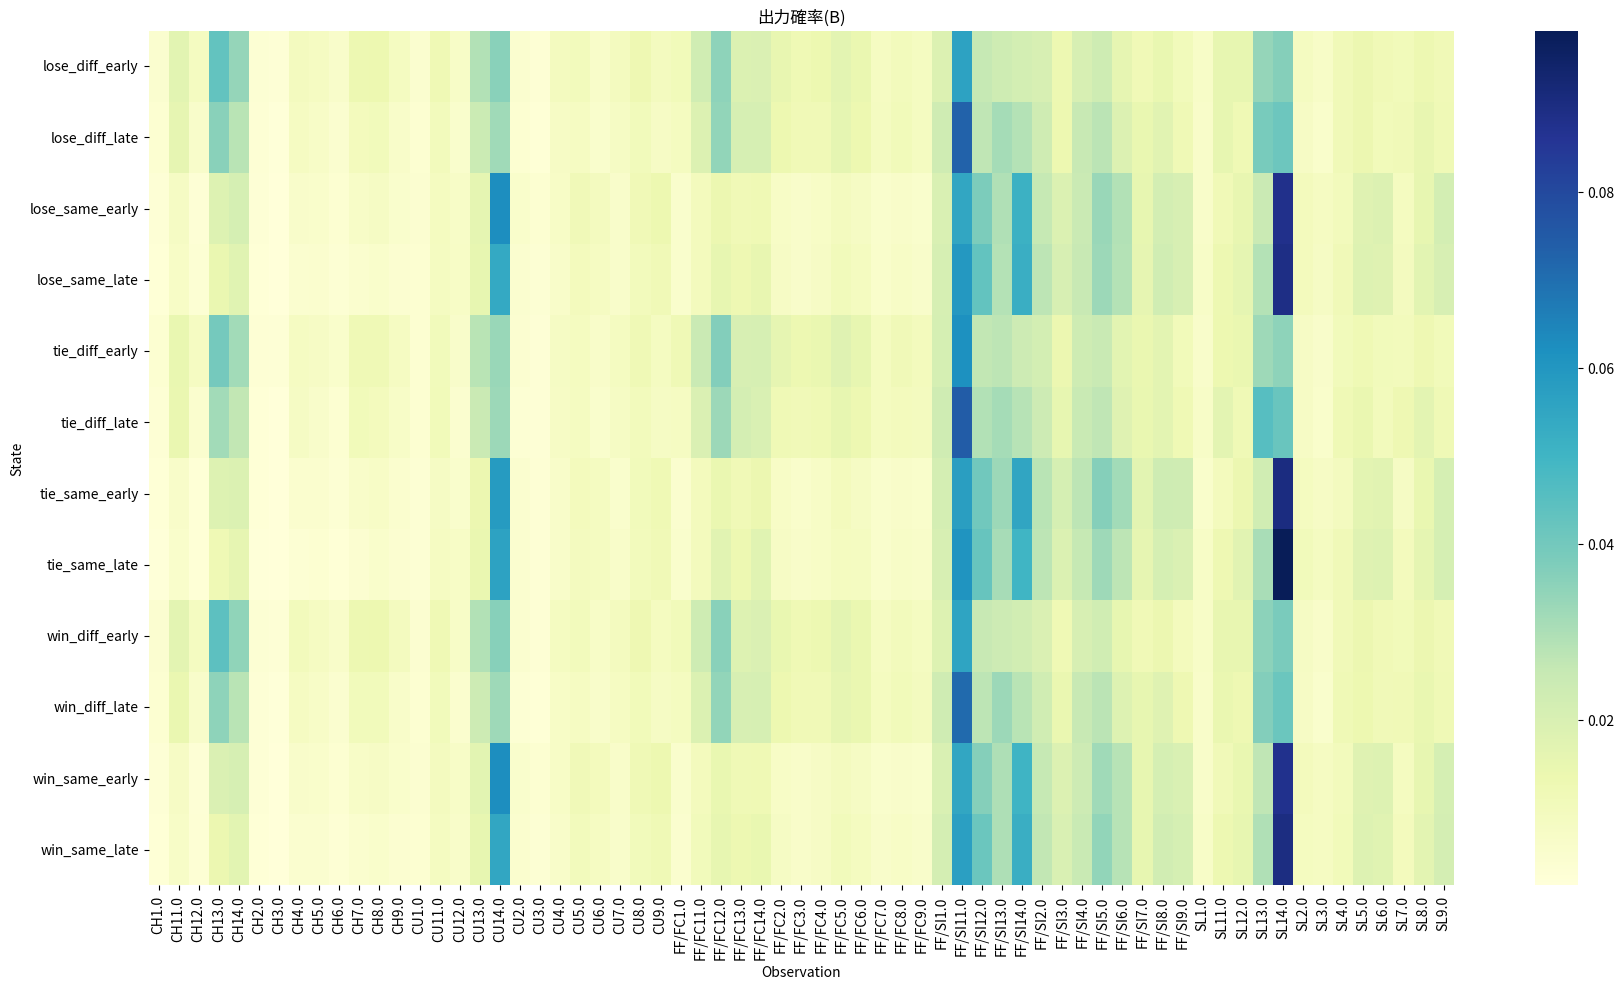

In [29]:
plot_emission_matrix(B)

In [30]:
from scipy.special import rel_entr
from scipy.stats import entropy

# KLダイバージェンス
def safe_kl(p, q, eps=1e-10):
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)
    return np.sum(rel_entr(p, q))

kl_per_state = [safe_kl(B[i], B_pred_mapped[i]) for i in range(n_states)]
mean_kl = np.mean(kl_per_state)

# エントロピー（出力分布の曖昧さ）
entropies = [entropy(row + 1e-10) for row in B_pred_mapped]

# 表示
for i, (kl, ent) in enumerate(zip(kl_per_state, entropies)):
    print(f"状態 {i}: KL={kl:.4f}, Entropy={ent:.4f}")
print(f"\n▼ 平均KLダイバージェンス: {mean_kl:.5f}")


状態 0: KL=0.4865, Entropy=3.7121
状態 1: KL=1.1650, Entropy=2.9713
状態 2: KL=0.3264, Entropy=3.4948
状態 3: KL=0.6151, Entropy=3.5073
状態 4: KL=1.9326, Entropy=2.8452
状態 5: KL=0.6730, Entropy=3.3575
状態 6: KL=0.5629, Entropy=3.8412
状態 7: KL=0.4441, Entropy=3.4316
状態 8: KL=0.7998, Entropy=3.5258
状態 9: KL=2.2965, Entropy=3.5501
状態 10: KL=1.0645, Entropy=2.9909
状態 11: KL=0.6223, Entropy=3.2427

▼ 平均KLダイバージェンス: 0.91572


In [31]:
from collections import defaultdict

pitcher_kl_dict = {}
pitchers = df["pitcher"].unique()

for pid in pitchers:
    pitcher_df = df[(df["pitcher"] == pid) & (df["split"] == "test")]

    # 状態 × 観測値 の頻度カウント
    B_count = np.zeros((n_states, n_obs))

    for _, row in pitcher_df.iterrows():
        s = row["situation_encoded"]
        o = row["obs_encoded"]
        B_count[s, o] += 1

    # 出力確率へ正規化（0割対策付き）
    B_sum = B_count.sum(axis=1, keepdims=True)
    B_true_pitcher = np.divide(B_count, B_sum, where=(B_sum != 0))

    # KLダイバージェンス（safe_kl 関数は前と同じ）
    kl_vals = []
    for i in range(n_states):
        kl_vals.append(safe_kl(B_true_pitcher[i], B_pred_mapped[i]))

    mean_kl = np.mean(kl_vals)
    pitcher_kl_dict[pid] = mean_kl


KeyboardInterrupt: 

再現度が高い（KL小）投手:
        KL_divergence
663359  -1.146000e-07
701619  -1.146000e-07
640902  -1.146000e-07
623507  -1.146000e-07
663971  -1.146000e-07
642558  -1.146000e-07
660634  -1.146000e-07
689379  -1.146000e-07
673862  -1.146000e-07
640461  -1.146000e-07

再現度が低い（KL大）投手:
        KL_divergence
681584            NaN
642216            NaN
685107            NaN
676661            NaN
681544            NaN
678013            NaN
805728            NaN
656550            NaN
680736            NaN
571771            NaN

▼ 全投手の平均KLダイバージェンス: 12.42940


<Figure size 1000x400 with 0 Axes>

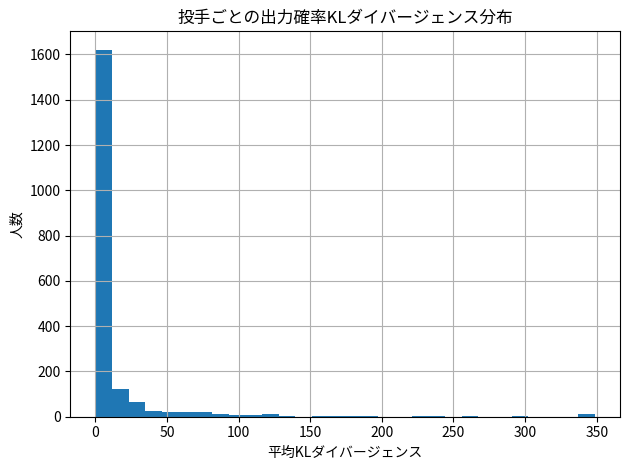

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

kl_df = pd.DataFrame.from_dict(pitcher_kl_dict, orient='index', columns=['KL_divergence'])
kl_df = kl_df.sort_values('KL_divergence')

# 上位10人・下位10人
print("再現度が高い（KL小）投手:")
print(kl_df.head(10))

print("\n再現度が低い（KL大）投手:")
print(kl_df.tail(10))

# 全体の平均KLダイバージェンス
mean_pitcher_kl = kl_df["KL_divergence"].mean()
print(f"\n▼ 全投手の平均KLダイバージェンス: {mean_pitcher_kl:.5f}")

# 全体分布
plt.figure(figsize=(10, 4))
kl_df.hist(bins=30)
plt.title("投手ごとの出力確率KLダイバージェンス分布")
plt.xlabel("平均KLダイバージェンス")
plt.ylabel("人数")
plt.tight_layout()
plt.show()


In [ ]:
invalid_pitchers = kl_df[kl_df["KL_divergence"].isna()].index.tolist()
print(f"\n▼ 出力確率が全く得られなかった投手数: {len(invalid_pitchers)}")



▼ 出力確率が全く得られなかった投手数: 73


In [44]:
import pickle

# 読み込み
with open('trained_hmm_ininng.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [45]:
all_preds_loaded = []
all_true_loaded = []

# dfをtestだけに絞る
test_df = df[df["split"] == "test"]

for (pid, game), group in test_df.groupby(["pitcher", "game_pk"]):
    states = group["situation_encoded"].values
    obs = group["obs_encoded"].values

    if len(states) < 2:
        continue

    pred = loaded_model.predict(obs.reshape(-1, 1))  # predictは2次元期待
    all_preds_loaded.extend(pred)
    all_true_loaded.extend(states[:len(pred)])


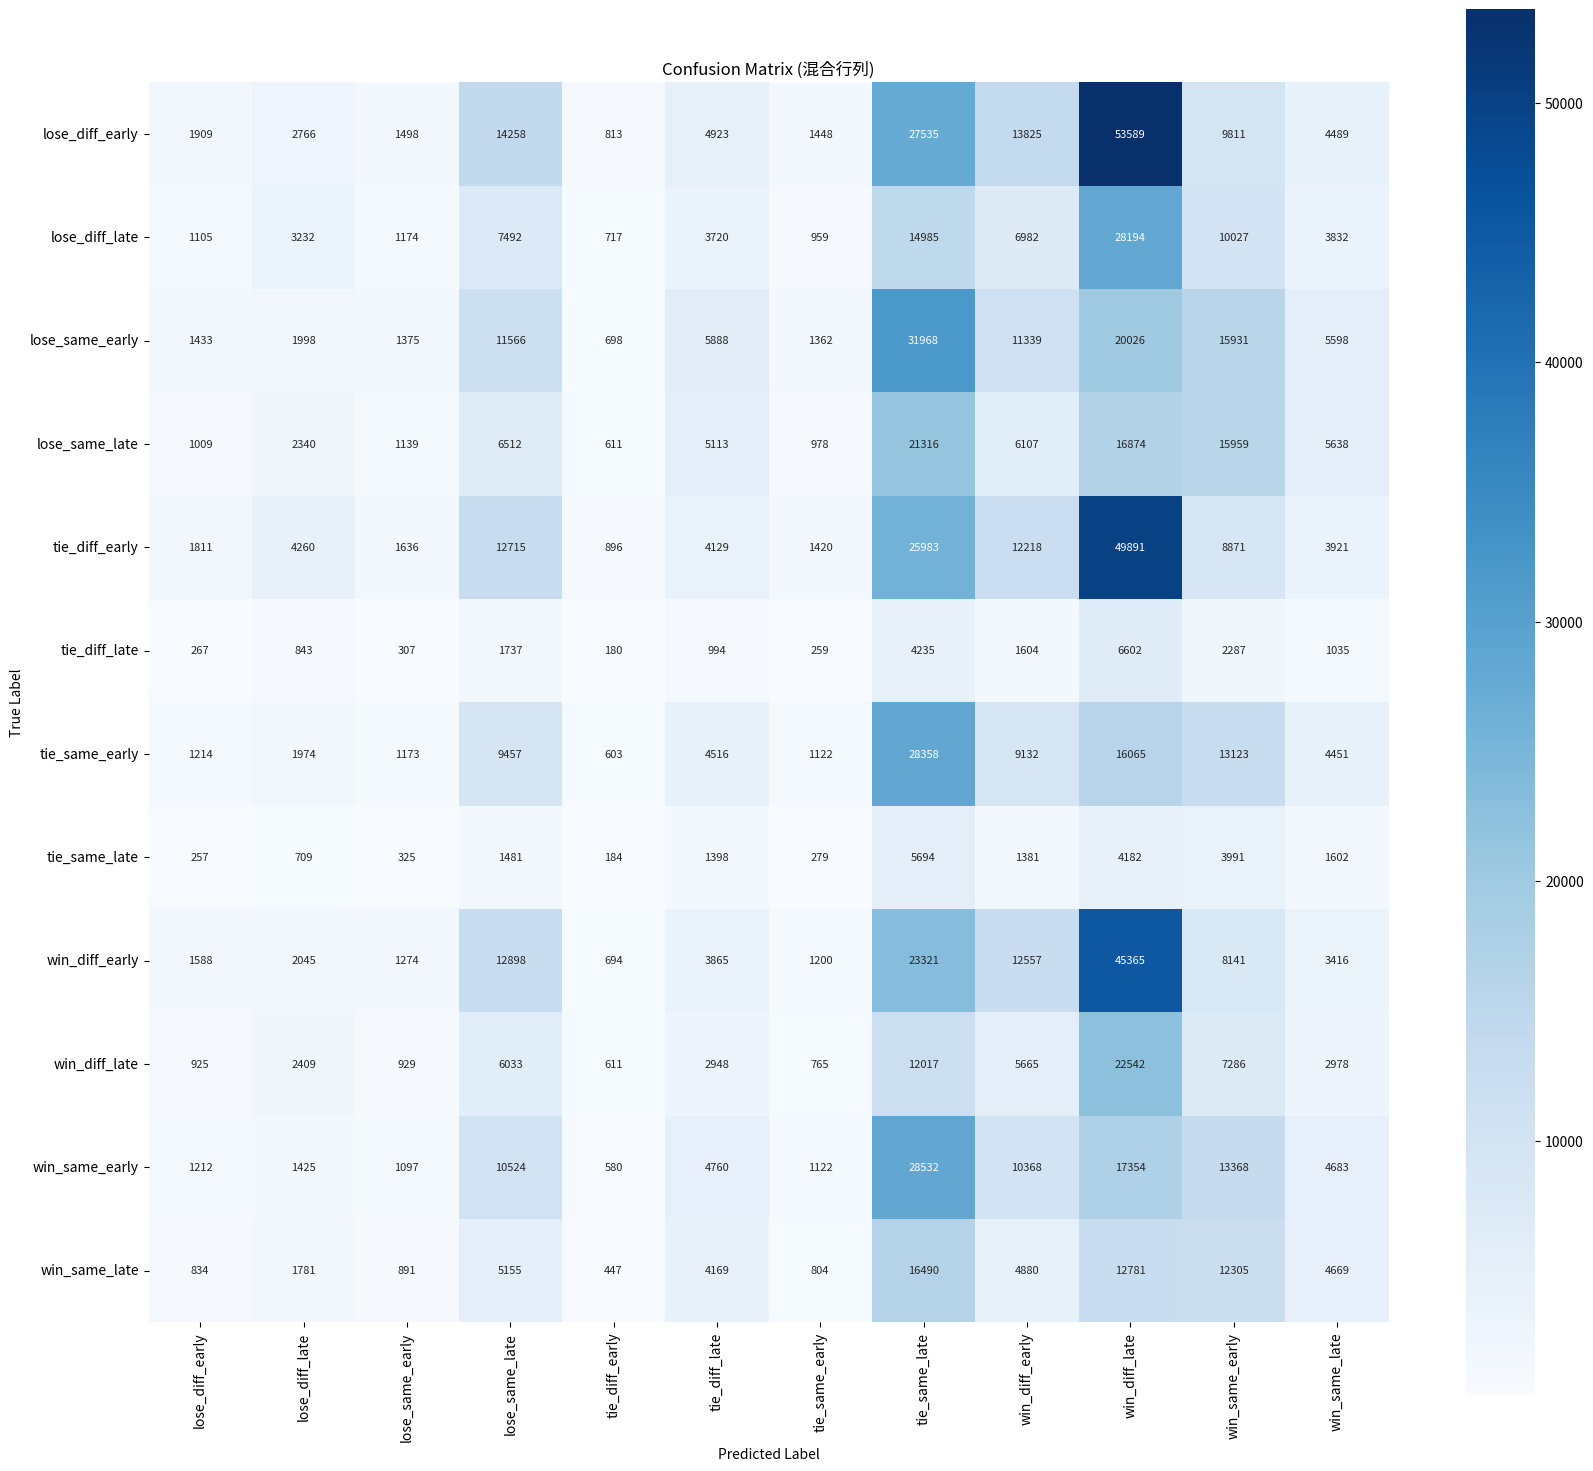

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix を作成
cm = confusion_matrix(all_true_loaded, all_preds_loaded, labels=range(n_states))

# ラベルを本来のcount_strに戻す
state_labels = state_encoder.inverse_transform(np.arange(n_states))

# サイズ大きめで
plt.figure(figsize=(20, 18))
sns.heatmap(cm, cmap='Blues', square=True, cbar=True, annot=True, fmt='d', 
            xticklabels=state_labels, yticklabels=state_labels, annot_kws={"size":8})

plt.title("Confusion Matrix (混合行列)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)  # 横ラベル回転させた方が見やすい
plt.yticks(rotation=0)   # 縦ラベルはそのまま
plt.show()


In [47]:
import numpy as np

accuracy_loaded = np.mean(np.array(all_preds_loaded) == np.array(all_true_loaded))
print(f"正解率 (Loaded HMM model): {accuracy_loaded:.4f}")


正解率 (Loaded HMM model): 0.0738


In [57]:
# 元のラベルに逆変換
true_labels = state_encoder.inverse_transform(all_true_loaded)
pred_labels = state_encoder.inverse_transform(all_preds_loaded)

def is_similar_context(true_label, pred_label):
    # true_label, pred_labelを要素に分解する（カンマ区切り前提）
    # 例："win_diff_early" → ['win', 'diff', 'early']
    t_win_lose, t_diff_same, t_early_late = true_label.split('_')
    p_win_lose, p_diff_same, p_early_late = pred_label.split('_')
    
    score = 0
    
    # 点差が同じならスコア加算
    if t_win_lose == p_win_lose:
        score += 1
        
    # 左右（same/diff）が同じなら加点
    if t_diff_same == p_diff_same:
        score += 1
        
    # イニング帯（early/late）が同じなら加算
    if t_early_late == p_early_late:
        score += 1
    
    # 全部合ってたらスコア3、2つ合ってたら2、みたいな
    return score >= 2  # 2項目以上合ってたら「似てる」とみなす

# ゆるい正解率計算
similar_correct = sum(is_similar_context(t, p) for t, p in zip(true_labels, pred_labels))
similar_accuracy = similar_correct / len(true_labels)

print(f"ゆるい正解率: {similar_accuracy:.4f}")


ゆるい正解率: 0.4024


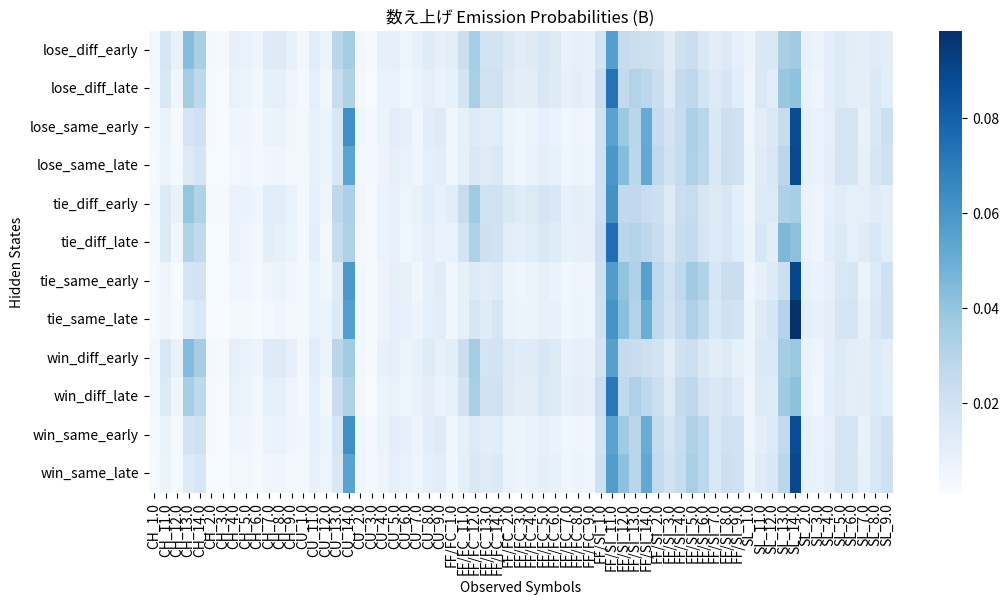

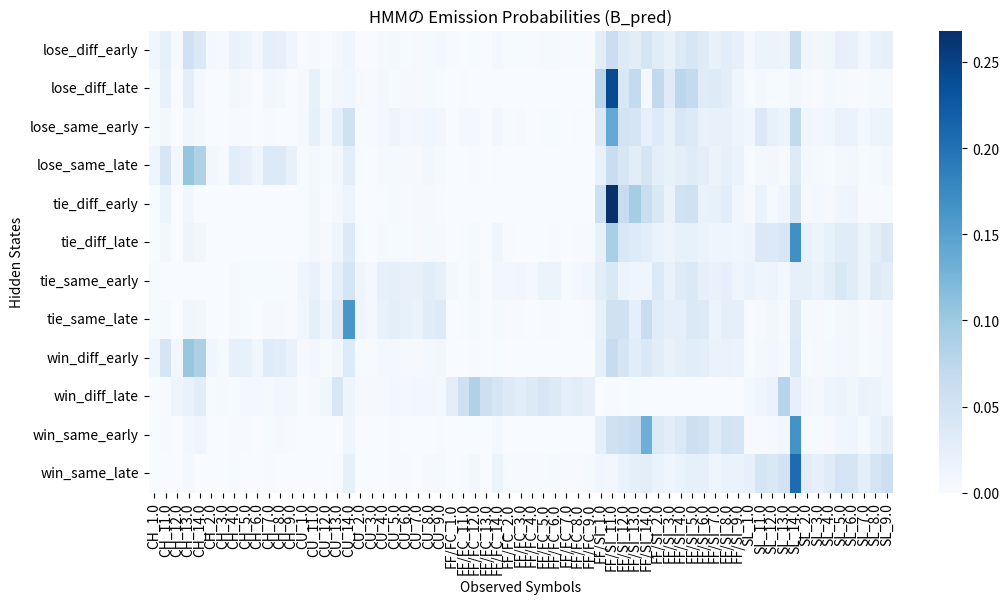

In [55]:
import seaborn as sns
# 読み込んだHMMから出力確率を取り出す
B_pred = loaded_model.emissionprob_
# 観測値のラベルを復元
obs_labels = obs_encoder.inverse_transform(np.arange(B.shape[1]))

# 頻度ベースB
plt.figure(figsize=(12, 6))
sns.heatmap(B, cmap="Blues",xticklabels=obs_labels,yticklabels=state_labels)
plt.title("数え上げ Emission Probabilities (B)")
plt.xlabel("Observed Symbols")
plt.ylabel("Hidden States")
plt.show()

# 学習後B_pred
plt.figure(figsize=(12, 6))
sns.heatmap(B_pred, cmap="Blues",xticklabels=obs_labels,yticklabels=state_labels)
plt.title("HMMの Emission Probabilities (B_pred)")
plt.xlabel("Observed Symbols")
plt.ylabel("Hidden States")
plt.show()


In [43]:
print(B_pred)

[[7.89593791e-04 6.10055059e-03 4.65635425e-05 ... 1.42885329e-03
  1.58212872e-03 4.36117604e-03]
 [8.62202011e-05 5.79100300e-06 6.87381426e-05 ... 1.91139698e-02
  2.48301667e-02 7.57423008e-03]
 [1.52310058e-03 6.98605314e-03 4.36417377e-04 ... 1.12271757e-03
  2.27872867e-03 3.62487411e-03]
 ...
 [1.94076087e-03 3.53880244e-03 2.65086983e-02 ... 6.12188559e-03
  5.24631402e-03 2.78333864e-03]
 [2.91569564e-06 4.86471255e-03 2.29728928e-08 ... 3.60524659e-03
  6.30471493e-03 1.06088068e-02]
 [8.16383181e-04 5.80938426e-03 7.25304493e-05 ... 7.38828219e-03
  1.68684123e-02 2.16263221e-02]]


In [53]:
from scipy.special import rel_entr  # KLダイバージェンス用

kl_list = []

# testデータだけ使う
test_df = df[df["split"] == "test"]

for pid, group in test_df.groupby("pitcher"):
    obs_counts = group["obs_encoded"].value_counts().reindex(range(B.shape[1]), fill_value=0)
    
    # 実際の観測確率（頻度ベース）
    p_true = obs_counts.values / obs_counts.values.sum()
    
    # モデル推定確率（学習したモデルで推定）
    # 推定には、そのピッチャーの「隠れ状態」推定が必要
    try:
        pred_states = loaded_model.predict(group["obs_encoded"].values.reshape(-1, 1))
        # 推定された状態ごとに、B_predから観測確率を取り出す
        p_pred = B_pred[pred_states].mean(axis=0)  # 平均する
        
        # スムージング（0だとKLが無限大になるから、少しだけ足す）
        eps = 1e-8
        p_true = np.clip(p_true, eps, 1)
        p_pred = np.clip(p_pred, eps, 1)

        # KLダイバージェンス計算
        kl = np.sum(rel_entr(p_true, p_pred))
        kl_list.append(kl)

    except Exception as e:
        print(f"ピッチャー {pid} でエラー: {e}")
        continue

# 全ピッチャーのKLの平均
kl_mean = np.mean(kl_list)
print(f"全ピッチャーの平均KLダイバージェンス: {kl_mean:.6f}")


全ピッチャーの平均KLダイバージェンス: 0.506622


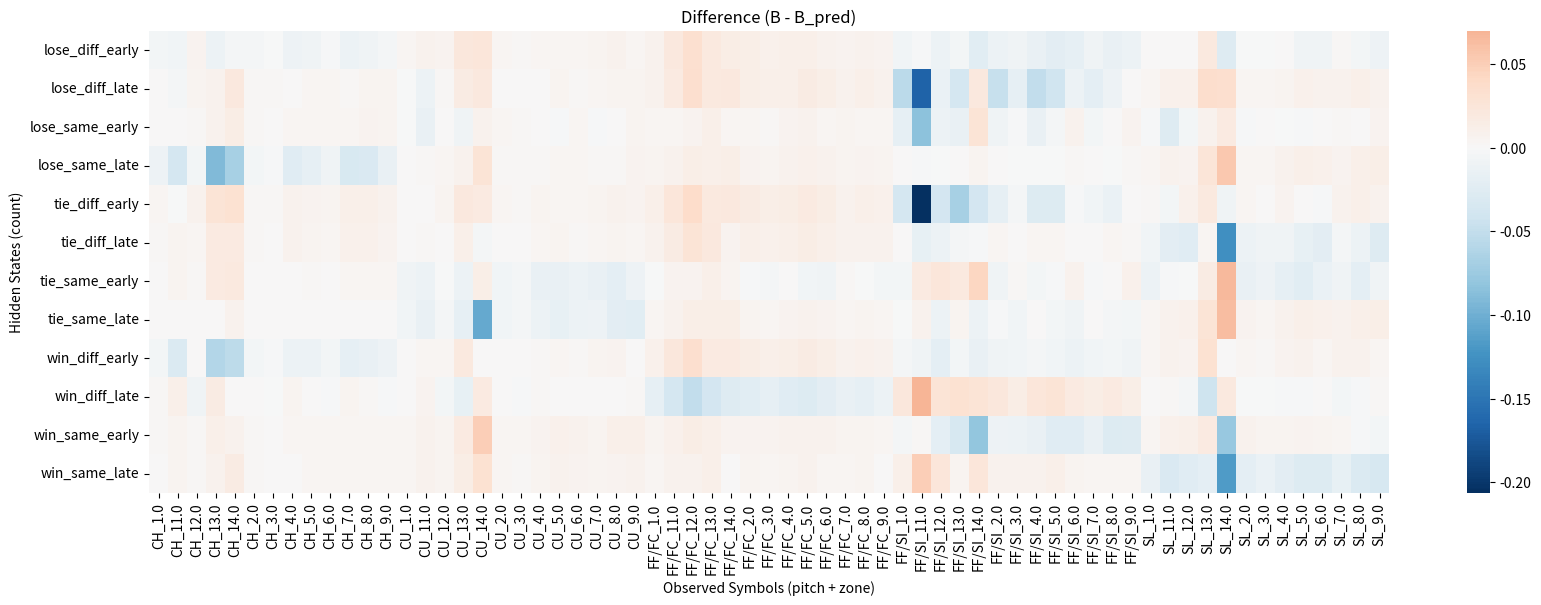

In [54]:
# 差分を計算
diff = B - B_pred

# 差分ヒートマップ
plt.figure(figsize=(20, 6))
sns.heatmap(diff, cmap="RdBu_r", center=0, xticklabels=obs_labels, yticklabels=state_labels)

plt.title("Difference (B - B_pred)")
plt.xlabel("Observed Symbols (pitch + zone)")
plt.ylabel("Hidden States (count)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
